In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BBBBBSBS'
meas='SNWD'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|3255.9381788602113|-563.8355681800143|-189.58171068737818|    240.8|BBBBBSBS|    43.9|    -71.3|       SNWD|0.11881505172944894|0.09238976506184808|0.08940226690972031|  0.401594911279398|USC00278612|2.9956911E7|     0|[28 5B F0 5B 24 5...|1987.0|
|359

### Plot Mean and Eigenvecs

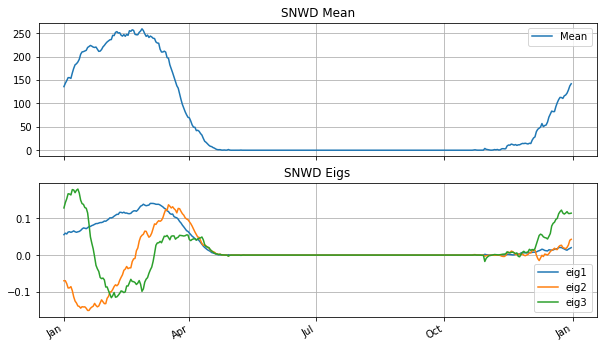

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

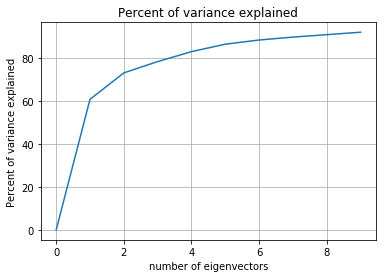

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

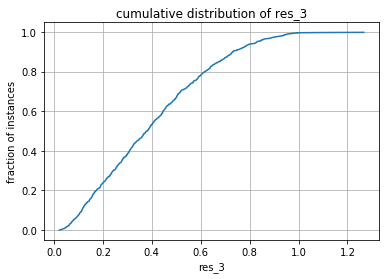

In [10]:
plot_CDF(df,'res_3')

In [11]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:3]

(u'USC00278612',
 1987.0,
 array([ 229.,  254.,  457.,  406.,  406.,  356.,  356.,  330.,  330.,
         330.,  483.,  508.,  457.,  432.,  432.,  432.,  432.,  432.,
         508.,  584.,  584.,  559.,  686.,  686.,  660.,  660.,  660.,
         635.,  610.,  610.,  762.,  737.,  686.,  686.,  635.,  610.,
         610.,  635.,  610.,  737.,  711.,  686.,  660.,  635.,  635.,
         635.,  635.,  635.,  610.,  610.,  584.,  584.,  584.,  584.,
         584.,  584.,  559.,  559.,  559.,  559.,  762.,  787.,  813.,
         762.,  737.,  686.,  660.,  635.,  635.,  635.,  610.,  610.,
         610.,  584.,  584.,  559.,  559.,  533.,  533.,  559.,  559.,
         457.,  457.,  381.,  305.,  254.,  203.,  178.,  127.,   51.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  305.,   76.,    0.,    0.,    0.,  

In [12]:
len(rows[0][-1])

365

In [13]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

43800

In [14]:
maxy

2012.0

In [15]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [16]:
keys = All.keys()
len(All[keys[2]])

43800

In [17]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [18]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00276945 9331
USC00173862 5444
USC00179720 728
US1MECM0007 356
USC00277253 3998
USC00179314 9555
USW00014611 10188
USC00271960 344
USC00272302 729
USC00271338 1080
USC00271339 2868
USW00014745 13828
USC00179547 2554
USC00275532 5836
USC00276070 1458
USC00275783 2809
USC00174193 3229
USC00275982 1824
USC00277833 2473
US1NHCR0001 345
US1MECM0023 340
US1MECM0020 702
USC00275813 2161
USC00176011 3283
USC00274234 3260
USC00275712 4586
USC00171131 1816
USW00004743 3284
USC00279278 1095
USC00172602 2105
USC00273626 5447
USC00192026 3517
USC00191992 1051
US1NHRC0018 698
USC00278606 675
USC00275412 15621
USC00194313 3207
USC00272800 5702
USC00173295 4003
USC00196977 2550
USC00196286 1095
USC00177479 8511
USC00172048 6113
USC00275371 365
USC00176881 2892
USC00271732 5110
USW00014710 3283
USC00279903 1460
USC00173026 1811
USC00274480 4237
USC00279865 1643
USC00279866 3506
USC00179051 2805
USC00172238 12277
USC00174656 719
USC00195285 2817
USC00193276 3193
USC00279740 5772
USC00170409 4363
USC0

In [19]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    #print All[station]
    A.append(All[station])
day_station_table=np.hstack([A])
print shape(day_station_table)

(86L, 43800L)


In [20]:
day_station_table

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [21]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  198.772898619
RMS removing mean-by-station=  178.100390676
RMS removing mean-by-day   =  84.2643369526


C:\Users\kdhiman\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: Mean of empty slice


In [22]:
mean_by_station.shape

(86L,)

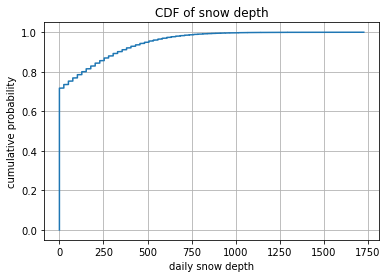

In [23]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of snow depth')
xlabel('daily snow depth')
ylabel('cumulative probability')

In [24]:
NN[-50:-1]

array([ 1499.,  1499.,  1499.,  1499.,  1499.,  1499.,  1499.,  1499.,
        1499.,  1499.,  1499.,  1499.,  1499.,  1524.,  1524.,  1524.,
        1524.,  1524.,  1524.,  1524.,  1524.,  1524.,  1524.,  1524.,
        1524.,  1524.,  1524.,  1524.,  1524.,  1524.,  1549.,  1549.,
        1549.,  1575.,  1575.,  1575.,  1575.,  1575.,  1575.,  1575.,
        1575.,  1575.,  1575.,  1600.,  1626.,  1626.,  1651.,  1651.,
        1676.])

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [62]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,250,500,500))

0.99701718564583286

In [26]:
A[:10]

[array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan])]

In [58]:
#USC00275412 15621
#USW00014764 13806

X=copy(All['USC00275412'])
Y=copy(All['USW00014764'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


15621
13806
11261
11261


In [63]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print exp(computeLogProb(X,Y))

m=11261,l=2735,n1=3366,n2=2814,LogPval=-0.378913
[ 0.68460513         inf]


C:\Users\kdhiman\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: overflow encountered in exp


### calculate the normalized log probability for each pair of stations.

In [29]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 1 2 3 4 5

C:\Users\kdhiman\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85


In [30]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[   0.  337.]
 [ 337.    0.]]
[[-0.4        -0.42392872]
 [-0.42392872 -0.4       ]]


(7396L,) (3500L,)


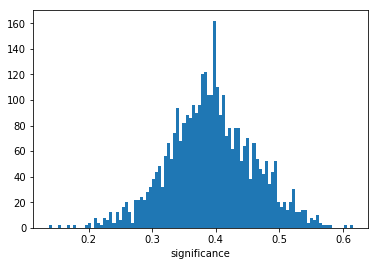

In [43]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')
savefig("significance_SNWD.png",bbox_inches='tight')

In [32]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

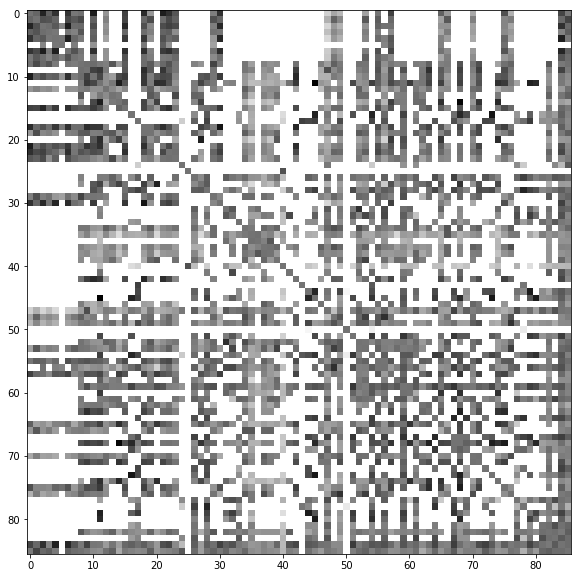

In [33]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [34]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00276945', u'USC00173862', u'USC00179720', u'US1MECM0007', u'USC00277253', u'USC00179314', u'USW00014611', u'USC00271960']


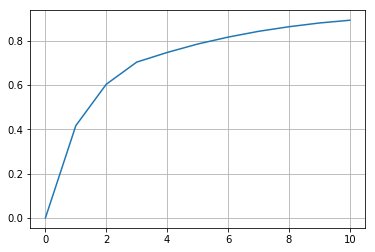

In [35]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [36]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

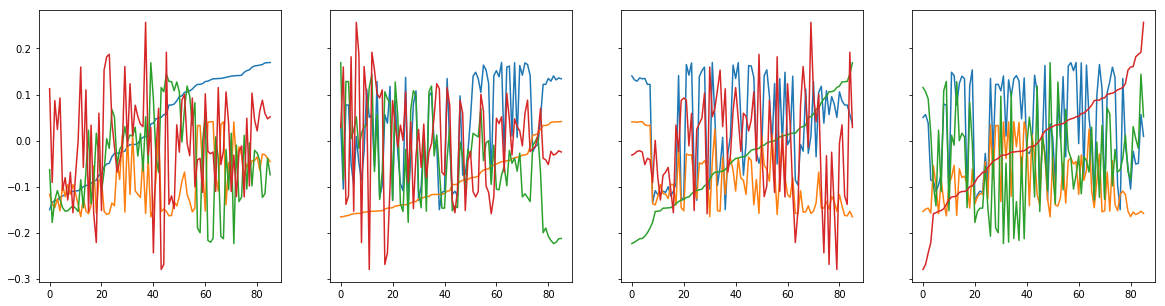

In [37]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [38]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

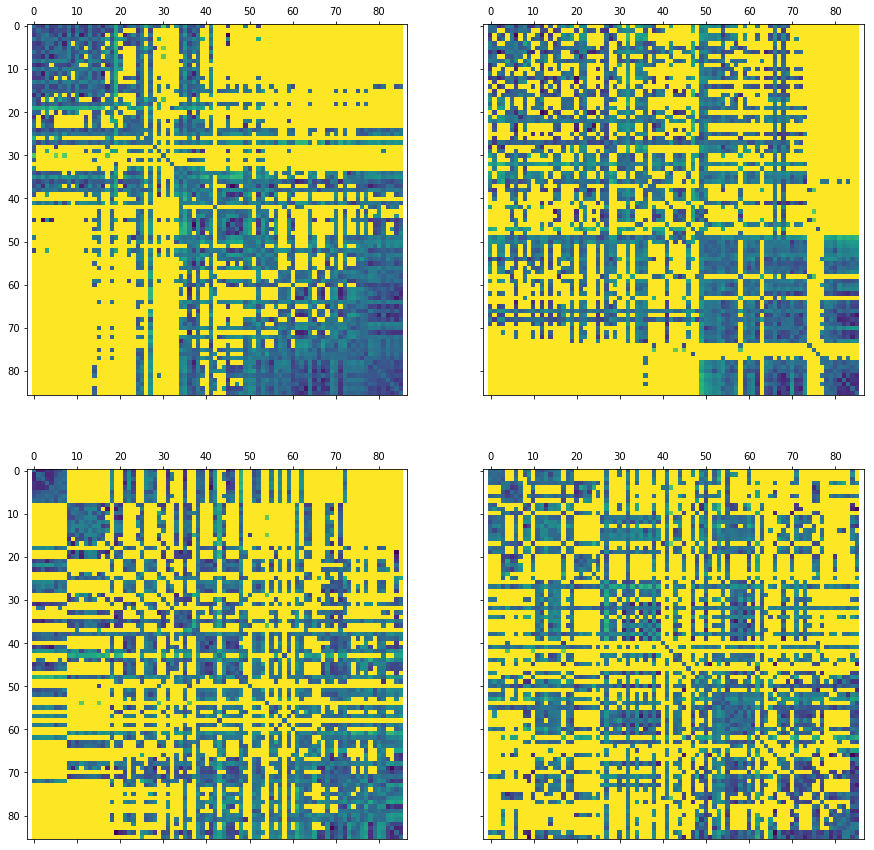

In [42]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1
savefig("block_eigen_SNWD.png",bbox_inches='tight')

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [40]:
from pickle import dump
with open(data_dir+'/SNWD_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    